In [29]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import load_npz
import time
import os

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, svm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectPercentile, SelectFpr, chi2, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from mlxtend.classifier import StackingCVClassifier

from tqdm import tqdm,trange
from collections import defaultdict,Counter
import alpha2digit
import text2num

import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'alpha2digit'

In [17]:
def preprocess(file, 
               process = None, 
               convert_to_seconds = False):
    curr_dir = os.path.dirname(os.path.realpath('__file__'))
    if not process:
        train_file = os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\'+file)
    else:
        train_file = os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_text_features_' + process + '\\' + file)

    data = pd.read_csv(train_file, index_col = False, delimiter = ',')
    if convert_to_seconds:
        tqdm.pandas(desc="Converting...")
        data['seconds'] = data['steps'].progress_apply(convert_step_to_time)
    return data

In [18]:
def read_pkl_file(files_name):
    file_paths = []
    for file_name in files_name:
        curr_dir = os.path.dirname(os.path.realpath('__file__'))
        file_paths.append(os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\', file_name))
    
    name = pickle.load(open(file_paths[0], "rb"))
    ingr = pickle.load(open(file_paths[1], "rb"))
    steps = pickle.load(open(file_paths[2], "rb"))
    return name, ingr, steps


def read_npz_file(files_name, use_scipy = True):
    file_paths = []
    for file_name in files_name:
        curr_dir = os.path.dirname(os.path.realpath('__file__'))
        file_paths.append(os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\' , file_name))
    
    if use_scipy:
        names = scipy.sparse.load_npz(file_paths[0])
        ingr = scipy.sparse.load_npz(file_paths[1])
        steps = scipy.sparse.load_npz(file_paths[2])
        return names, ingr, steps
    
    npz_names = np.load(file_paths[0])
    names = pd.DataFrame.from_dict({i: npz_names[i] for i in npz_names.files}, orient='index')

    npz_ingr = np.load(file_paths[1])
    ingr = pd.DataFrame.from_dict({i: npz_ingr[i] for i in npz_ingr.files}, orient='index')

    npz_steps = np.load(file_paths[2])
    steps = pd.DataFrame.from_dict({i: npz_steps[i] for i in npz_steps.files}, orient='index')
    return names,ingr,steps

def read_train_file(preprocess_method, files_name):
    file_paths = []
    for file_name in files_name:
        curr_dir = os.path.dirname(os.path.realpath('__file__'))
        file_paths.append(os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\', preprocess_method, file_name))
    
    names = pd.read_csv(file_paths[0], index_col = False, delimiter = ',', header=None)
    ingr = pd.read_csv(file_paths[1], index_col = False, delimiter = ',', header=None)
    steps = pd.read_csv(file_paths[2], index_col = False, delimiter = ',', header=None)
    
    return names, ingr, steps

In [24]:
time_retrieval = lambda words, sentence : re.findall(re.compile('|'.join(
        [n + w + "\\b" for w in words for n in ["[0-9]+\s*","another ","few ","a ","an ","several "]])), sentence)

kw_retrieval = lambda words, sentence : re.findall(re.compile('|'.join(
        ["\\b" + w + "\\b" for w in words])), sentence)

def convert_step_to_time(step, keyword_check = True):
    total_time = 0 # in seconds
    times = defaultdict(list)
    time_unit = {"second":1, "minute":60, "hour":60*60}
    kw_dict = {"overnight":8, "night":8, "nights":8, "freeze":5, "refrigerate":3,
               "day":12, "cook on low":7, "slow cook":7, "crockpot":7, "crock pot":7,
               "cook low":7, "boil":1, "heat":1, "bread machine":1.5
               }
    
    # Iterate through each step to find time value using RE
    numeric_step = alpha2digit(step,'en')
    times["second"] = time_retrieval(["more seconds","more second","more secs","more sec","seconds","second","secs","sec","s"],numeric_step)
    times["minute"] = time_retrieval(["more minutes","more minute","more min","more mins","minutes","minute","min","mins","m","ms"],numeric_step)
    times["hour"] = time_retrieval(["more hours","more hour","more hrs","more hr","hours","hour","hrs","hr","h","hs"],numeric_step)
    special_keywords = kw_retrieval(kw_dict.keys(),numeric_step) if keyword_check else None

    for unit in time_unit.keys():
        #total_time += sum([float(re.findall(r'[0-9]+',t.split()[0])[0]) * time_unit[unit] for t in times[unit]])
        count = 0
        for t in times[unit]:
            numerator = t.split()[0]

            if numerator in ["another","a","an"]:
                count = 1
            elif numerator in ["few","several"]:
                count = 4
            else:
                count = float(re.findall(r'[0-9]+',numerator)[0])

            total_time += count * time_unit[unit]

    if keyword_check and not total_time and special_keywords:
        total_time += 60*60*kw_dict[special_keywords[0]]

    if total_time == 0:
        return None
    return total_time

In [2]:
train_data = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_train.csv', index_col = False, delimiter = ',', header=0)
train_steps = train_data['steps']

v = CountVectorizer(stop_words='english').fit(train_steps)

In [5]:
print(v.vocabulary_['boil'])


2473

In [22]:
#train_data['boil?']=[bool(npz[(i,v.vocabulary_['boil'])]) for i in range(len(train_data))]
#train_data['grill?']=[bool(npz[(i,v.vocabulary_['grill'])]) for i in range(len(train_data))]
#train_data
#train_data['steps'].iloc[39996]

In [3]:
npz = load_npz('COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\train_steps_vec.npz')

correlated_words = ['20', '25', '30', '35', '350', '40', '45', 'add', 'bake', 'baking', 'beat', 'butter', 'cake', 'casserole',
                   'chicken', 'cooker', 'cool', 'cover', 'crock', 'crockpot', 'degrees', 'dish', 'dough', 'flour',
                   'hour', 'hours', 'inch', 'low', 'meat', 'minutes', 'mixture', 'oven', 'pan', 'pot', 'potatoes',
                   'preheat', 'remove', 'roast', 'simmer', 'slow']

for word in correlated_words:
    train_data[word + '?']=[bool(npz[(i,v.vocabulary_[word])]) for i in range(len(train_data))]
train_data = train_data.drop(['name', 'steps', 'ingredients'], axis=1)

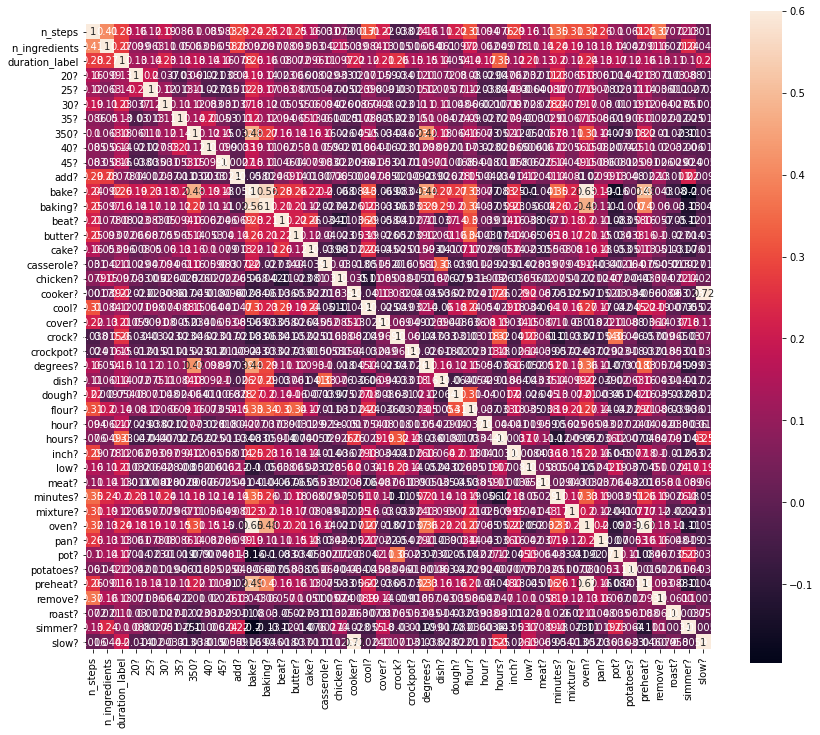

In [19]:
# 50 new features - Confusion matrix

plt.figure(figsize=(14,12))
# foo = sns.heatmap(data.drop('PassengerId',axis=1).corr(), vmax=0.6, square=True, annot=True)
foo = sns.heatmap(train_data.drop(['name', 'steps', 'ingredients'], axis=1).corr(), vmax=0.6, square=True, annot=True)

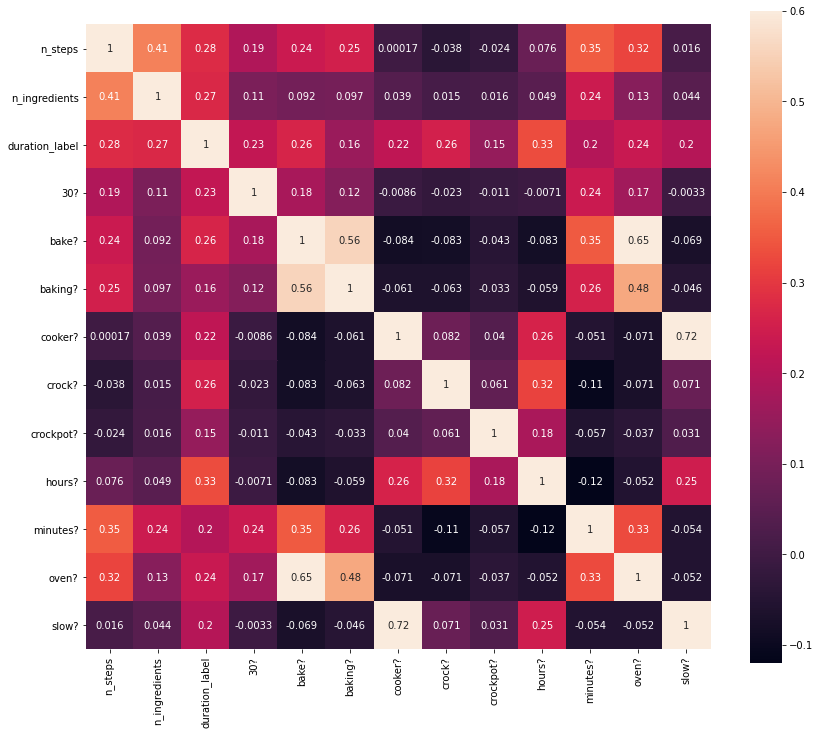

In [25]:
# 10 best new features - Confusion matrix

correlated_words = ['30', 'bake', 'baking', 'cooker', 'crock', 'crockpot', 'hours','minutes', 'oven','slow']

for word in correlated_words:
    train_data[word + '?']=[bool(npz[(i,v.vocabulary_[word])]) for i in range(len(train_data))]
    
plt.figure(figsize=(14,12))

foo = sns.heatmap(train_data.drop(['name', 'steps', 'ingredients'], axis=1).corr(), vmax=0.6, square=True, annot=True)

## Train and evaluate on Chi-square feature selection

Training data consists of best 50 features selected from Chi-squared (on 'steps' counter vectoriser), with n_steps and n_ingredients, given from raw dataset.

In [4]:
train_data

,n_steps,n_ingredients,duration_label,20?,25?,30?,35?,350?,40?,45?,...,mixture?,oven?,pan?,pot?,potatoes?,preheat?,remove?,roast?,simmer?,slow?
0,6,12,2.0,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,9,5,2.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,15,10,2.0,False,False,True,True,False,False,False,...,True,False,True,False,False,False,True,False,True,False
3,10,8,2.0,False,False,False,False,False,True,False,...,True,False,False,False,False,False,False,False,True,False
4,6,5,2.0,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,6,13,1.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
39996,15,16,2.0,True,False,True,False,True,True,False,...,True,True,True,True,True,True,False,False,True,False
39997,5,8,1.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
39998,7,17,2.0,True,True,True,False,False,True,False,...,True,False,True,False,True,False,False,False,True,False


In [5]:
X = train_data.drop(['duration_label'], axis=1)
y = train_data['duration_label']

### Base classifier testing and evaluating

In [9]:
import warnings
warnings.filterwarnings("ignore")

models = [DummyClassifier(strategy='most_frequent'),
          GaussianNB(),
          MultinomialNB(),
          LinearSVC(),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          KNeighborsClassifier(),
          LogisticRegression(),
          AdaBoostClassifier(),
          GradientBoostingClassifier()]
titles = ['Zero-R',
          'GNB',
          'MNB',
          'LinearSVC',
          'Decision Tree',
          'Random Forest',
          'KNN',
          'Logistic Regression',
          'Ada Boosting',
          'Gradient Boosting']
scores = []
times = []

for title, model in zip(titles, models):
    start = time.time()
    acc = np.mean(cross_val_score(model, X, y, cv=10))
    end = time.time()
    t = end - start
    scores.append(acc)
    times.append(t)
    print(title, "Accuracy:",acc, 'time:', t)
    

Zero-R Accuracy: 0.5061500000000001 time: 0.13763213157653809
GNB Accuracy: 0.728975 time: 1.4015047550201416
MNB Accuracy: 0.7061 time: 1.0055322647094727
LinearSVC Accuracy: 0.7785 time: 127.00626063346863
Decision Tree Accuracy: 0.7091249999999999 time: 3.8438775539398193
Random Forest Accuracy: 0.778875 time: 56.47395324707031
KNN Accuracy: 0.7093999999999999 time: 38.90107011795044
Logistic Regression Accuracy: 0.7827 time: 16.75643515586853
Ada Boosting Accuracy: 0.769925 time: 66.29918193817139
Gradient Boosting Accuracy: 0.786175 time: 169.36583614349365


In [12]:
models = [BaggingClassifier(LinearSVC()),
          BaggingClassifier(RandomForestClassifier()),
          BaggingClassifier(LogisticRegression()),
          BaggingClassifier(AdaBoostClassifier()),
          BaggingClassifier(GradientBoostingClassifier())]
titles = ['LinearSVC',
          'Random Forest',
          'Logistic Regression',
          'Ada Boosting',
          'Gradient Boosting']

for title, model in zip(titles, models):
    start = time.time()
    acc = np.mean(cross_val_score(model, X, y, cv=10))
    end = time.time()
    t = end - start
    scores.append(acc)
    times.append(t)
    print(title, "Accuracy:",acc, 'time:', t)


LinearSVC Accuracy: 0.782925 time: 835.4544847011566
Random Forest Accuracy: 0.784975 time: 382.2610750198364
Logistic Regression Accuracy: 0.7830250000000001 time: 162.4518599510193
Ada Boosting Accuracy: 0.7718750000000001 time: 616.5306107997894
Gradient Boosting Accuracy: 0.786775 time: 1208.8580510616302


In [13]:
models = [LinearSVC(),
          RandomForestClassifier(),
          LogisticRegression(),
          AdaBoostClassifier(),
          GradientBoostingClassifier()]

sclf = StackingCVClassifier(classifiers=models,
                            meta_classifier=DecisionTreeClassifier())

start = time.time()
print('acc: \t', cross_val_score(sclf,X,y, cv = 10).mean())
end = time.time()
print('time: \t', end - start)

acc: 	 0.786625
time: 	 1969.8120839595795


In [26]:
c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
c3 = KNeighborsClassifier(n_neighbors=38)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

start = time.time()
print(cross_val_score(sclf,X,y).mean())
print('Process takes ',time.time()-start, 'seconds')

0.7899749999999999
Process takes  507.82549595832825 seconds


### Evaluate testing data

In [28]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

test_data = preprocess('recipe_test.csv', convert_to_seconds=True)#pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_train.csv')
npz = load_npz('COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\train_steps_vec.npz')

correlated_words = ['20', '25', '30', '35', '350', '40', '45', 'add', 'bake', 'baking', 'beat', 'butter', 'cake', 'casserole',
                   'chicken', 'cooker', 'cool', 'cover', 'crock', 'crockpot', 'degrees', 'dish', 'dough', 'flour',
                   'hour', 'hours', 'inch', 'low', 'meat', 'minutes', 'mixture', 'oven', 'pan', 'pot', 'potatoes',
                   'preheat', 'remove', 'roast', 'simmer', 'slow']

for word in correlated_words:
    test_data[word + '?']=[bool(npz[(i,v.vocabulary_[word])]) for i in range(len(test_data))]
test_data = test_data.drop(['name', 'steps', 'ingredients'], axis=1)

'''
test = pd.concat([test_data,test_data_100],axis=1)
x100test = test.drop(['name','steps','ingredients'], axis=1)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x100)

x100test = imp.transform(x100test)

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = GaussianNB()#KNeighborsClassifier(n_neighbors=38)
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

sclf.fit(x100,y100)
Y_test = sclf.predict(x100test)

out = pd.DataFrame({'duration_label':Y_test})
out.index += 1
out.to_csv('output/out_'+'randomforest_gaussiannb_logisticreg'+'.csv',index_label = 'id')
'''

Converting...:   0%|                                                               | 1/10000 [00:00<00:09, 1002.46it/s]


NameError: name 'alpha2digit' is not defined